https://okumuralab.org/~okumura/python/t_u_test.html はヒストグラムを使っている点が非常によろしくない。

In [1]:
using Random
using Distributions
distname(dist) = replace(string(dist), r"{[^}]*}"=>"")
distname(dist::InverseGamma) = "InverseGamma(α=$(shape(dist)), θ=$(scale(dist)))"
using Plots
default(fmt=:png, legend=false, titlefontsize=10, plot_titlefontsize=10, size=(400, 200))
using HypothesisTests

# approximate Mann-Whitney U-testではデフォルトでは連続性補正がかかっている。
# https://github.com/JuliaStats/HypothesisTests.jl/blob/master/src/mann_whitney.jl#L236-L249
my_pvalue(x::ApproximateMannWhitneyUTest; continuity_correction=true) =
    continuity_correction ? pvalue(x) : 2ccdf(Normal(), abs(x.mu)/x.sigma)

function p_values(distx, m, disty, n; niters=10^6, continuity_correction=true)
    pvalue_student_t = zeros(niters)
    pvalue_welch_t = zeros(niters)
    pvalue_mann_whitney_u_exact = zeros(niters)
    pvalue_mann_whitney_u_approximate = zeros(niters)
    nth = Threads.nthreads(:interactive) + Threads.nthreads(:default)
    tmpx = [zeros(m) for _ in 1:nth]
    tmpy = [zeros(n) for _ in 1:nth]
    Threads.@threads :static for i in 1:niters
        tid = Threads.threadid()
        datax = rand!(distx, tmpx[tid])
        datay = rand!(distx, tmpy[tid])
        pvalue_student_t[i] = pvalue(EqualVarianceTTest(datax, datay))
        pvalue_welch_t[i] = pvalue(UnequalVarianceTTest(datax, datay))
        pvalue_mann_whitney_u_exact[i] = pvalue(ExactMannWhitneyUTest(datax, datay))
        pvalue_mann_whitney_u_approximate[i] = my_pvalue(ApproximateMannWhitneyUTest(datax, datay); continuity_correction)
    end
    (; pvalue_student_t, pvalue_welch_t, pvalue_mann_whitney_u_exact, pvalue_mann_whitney_u_approximate)
end
    
function hist_p_values(distx, m, disty, n; niters=10^6, bin=0:0.05:1.05, continuity_correction=true)
    @time (; pvalue_student_t, pvalue_welch_t, pvalue_mann_whitney_u_exact, pvalue_mann_whitney_u_approximate) =
        p_values(distx, m, disty, n; niters, continuity_correction)
    P1 = histogram(pvalue_student_t; norm=true, c=1, alpha=0.5, title="Student t-test", bin)
    P2 = histogram(pvalue_welch_t; norm=true, c=2, alpha=0.5, title="Welch t-test", bin)
    P3 = histogram(pvalue_mann_whitney_u_exact; norm=true, c=3, alpha=0.5, title="exact Mann-Whitney U-test", bin)
    P4 = histogram(pvalue_mann_whitney_u_approximate; norm=true, c=4, alpha=0.5, title="approximate Mann-Whitney U-test", bin)
    plot(P1, P2, P3, P4; size=(640, 400), layout=(2, 2))
    plot!(plot_title="$(distname(distx)), m=$m vs. $(distname(disty)), n=$n")
end

_ecdf(A, x) = count(≤(x), A) / length(A)

function ecdf_p_values(distx, m, disty, n; niters=10^6, maxalpha=1, continuity_correction=true)
    @time (; pvalue_student_t, pvalue_welch_t, pvalue_mann_whitney_u_exact, pvalue_mann_whitney_u_approximate) =
        p_values(distx, m, disty, n; niters, continuity_correction)
    P1 = plot(x -> _ecdf(pvalue_student_t, x), 0, maxalpha; c=1, title="Student t-test")
    plot!(identity; ls=:dot, c=:gray, alpha=0.8)
    P2 = plot(x -> _ecdf(pvalue_welch_t, x), 0, maxalpha; c=2, title="Welch t-test")
    plot!(identity; ls=:dot, c=:gray, alpha=0.8)
    P3 = plot(x -> _ecdf(pvalue_mann_whitney_u_exact, x), 0, maxalpha; c=3, title="exact Mann-Whitney U-test")
    plot!(identity; ls=:dot, c=:gray, alpha=0.8)
    P4 = plot(x -> _ecdf(pvalue_mann_whitney_u_approximate, x), 0, maxalpha; c=4, title="approximate Mann-Whitney U-test")
    plot!(identity; ls=:dot, c=:gray, alpha=0.8)
    plot(P1, P2, P3, P4; size=(640, 640), layout=(2, 2))
    plot!(plot_title="$(distname(distx)), m=$m vs. $(distname(disty)), n=$n")
end

ecdf_p_values (generic function with 1 method)

## P値の経験分布のヒストグラム

  5.539864 seconds (60.88 M allocations: 4.523 GiB, 9.71% gc time, 271.08% compilation time: 45% of which was recompilation)


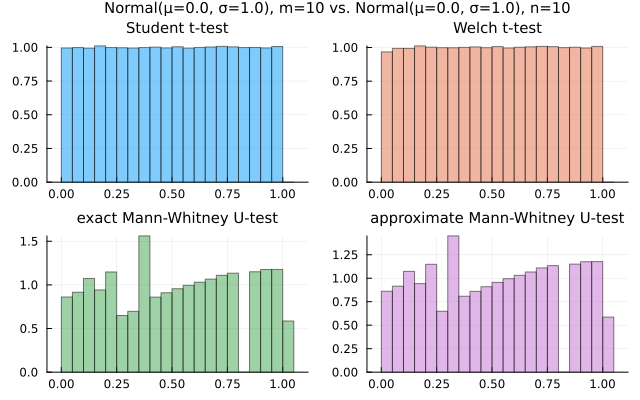

In [2]:
hist_p_values(Normal(), 10, Normal(), 10)

  1.100297 seconds (52.73 M allocations: 4.141 GiB, 30.76% gc time)


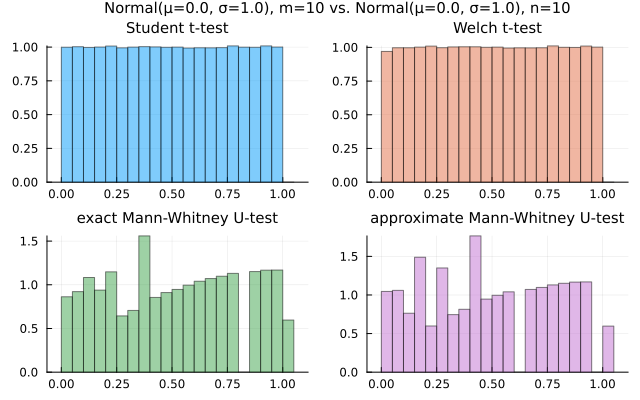

In [3]:
hist_p_values(Normal(), 10, Normal(), 10; continuity_correction=false)

  1.418782 seconds (52.74 M allocations: 4.141 GiB, 37.53% gc time)


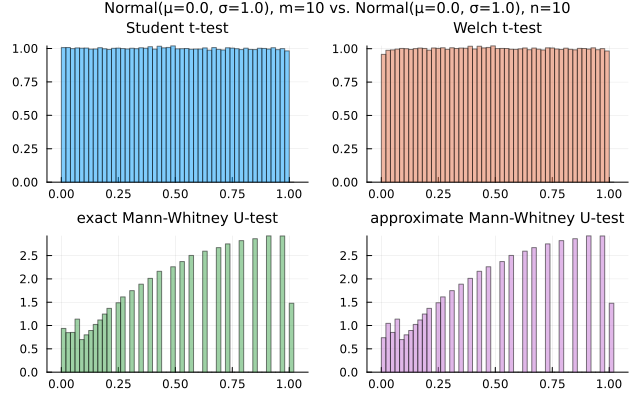

In [4]:
hist_p_values(Normal(), 10, Normal(), 10; bin=0:0.02:1.02)

  1.085306 seconds (52.74 M allocations: 4.142 GiB, 25.39% gc time)


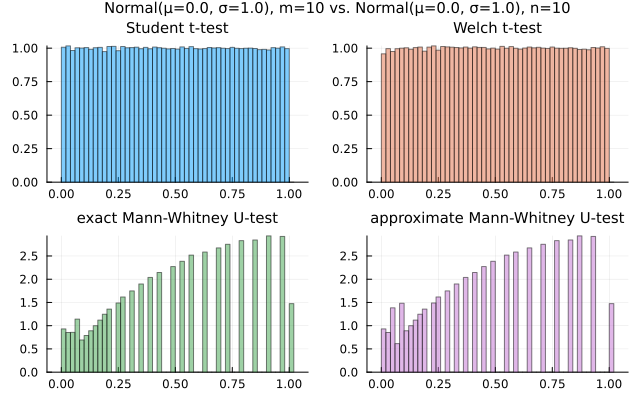

In [5]:
hist_p_values(Normal(), 10, Normal(), 10; bin=0:0.02:1.02, continuity_correction=false)

  1.229413 seconds (42.02 M allocations: 3.814 GiB, 34.75% gc time, 53.78% compilation time)


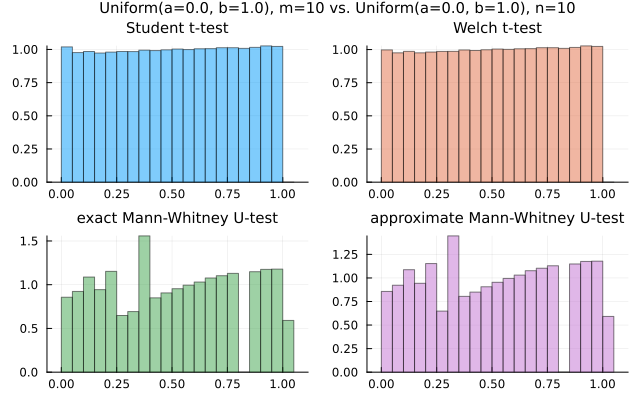

In [6]:
hist_p_values(Uniform(), 10, Uniform(), 10)

  0.989352 seconds (41.81 M allocations: 3.803 GiB, 28.54% gc time)


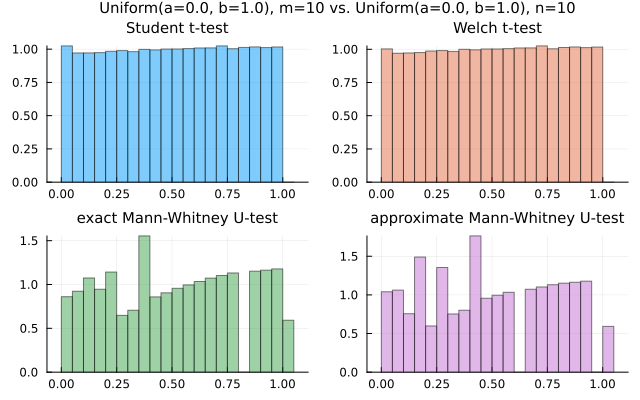

In [7]:
hist_p_values(Uniform(), 10, Uniform(), 10; continuity_correction=false)

  1.189944 seconds (41.82 M allocations: 3.805 GiB, 36.52% gc time)


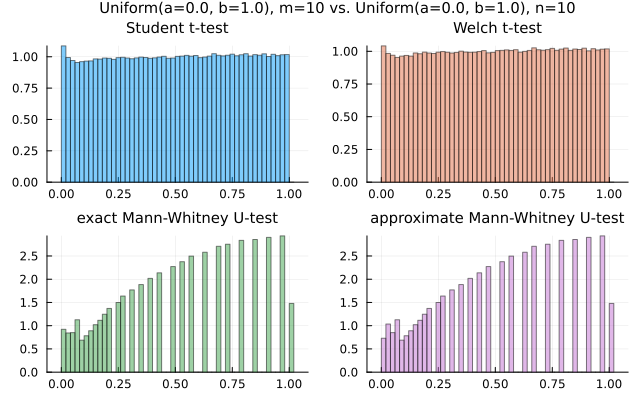

In [8]:
hist_p_values(Uniform(), 10, Uniform(), 10; bin=0:0.02:1.02)

  1.023727 seconds (41.82 M allocations: 3.803 GiB, 26.79% gc time)


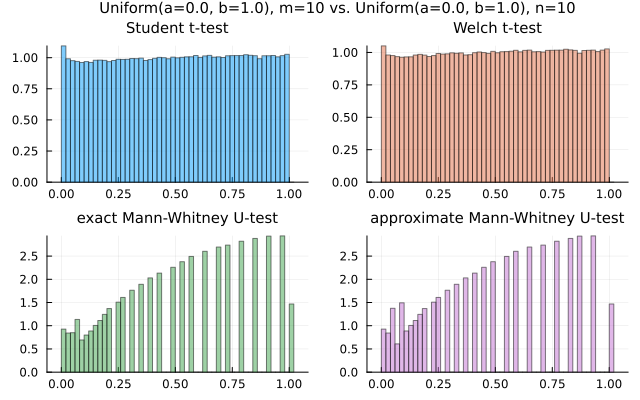

In [9]:
hist_p_values(Uniform(), 10, Uniform(), 10; bin=0:0.02:1.02, continuity_correction=false)

skewness(dist) = 41.952353926806026


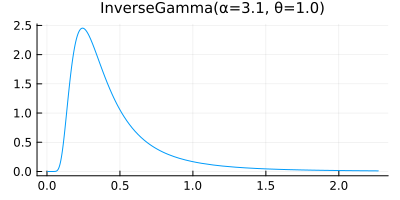

In [10]:
dist = InverseGamma(3.1, 1)
@show skewness(dist)
plot(x -> pdf(dist, x), 0, 5std(dist); title=distname(dist))

  1.319538 seconds (42.48 M allocations: 3.883 GiB, 33.93% gc time, 69.06% compilation time)


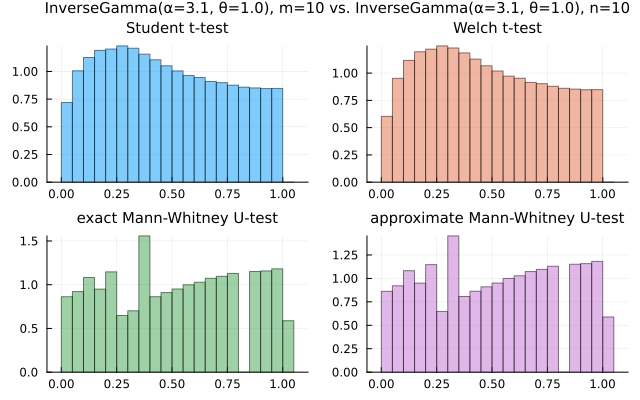

In [11]:
hist_p_values(InverseGamma(3.1, 1), 10, InverseGamma(3.1, 1), 10)

  1.040501 seconds (42.30 M allocations: 3.873 GiB, 26.07% gc time)


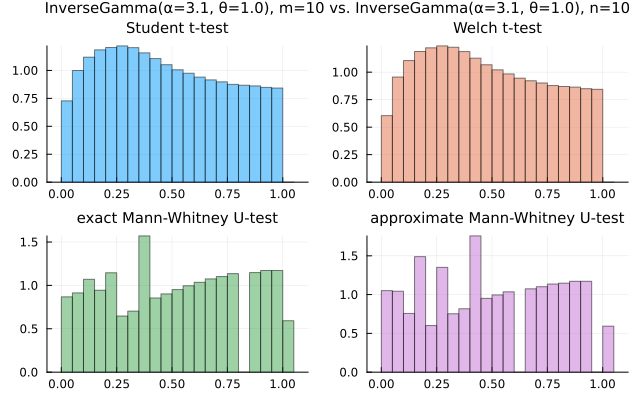

In [12]:
hist_p_values(InverseGamma(3.1, 1), 10, InverseGamma(3.1, 1), 10; continuity_correction=false)

  1.243228 seconds (42.31 M allocations: 3.874 GiB, 34.87% gc time)


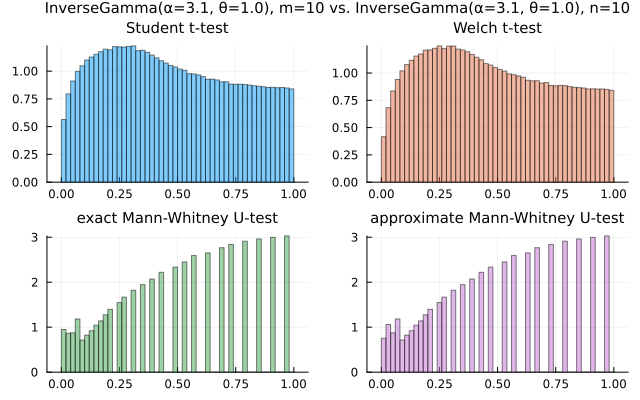

In [13]:
hist_p_values(InverseGamma(3.1, 1), 10, InverseGamma(3.1, 1), 10; bin=0:0.02:1)

  1.035328 seconds (42.31 M allocations: 3.874 GiB, 25.68% gc time)


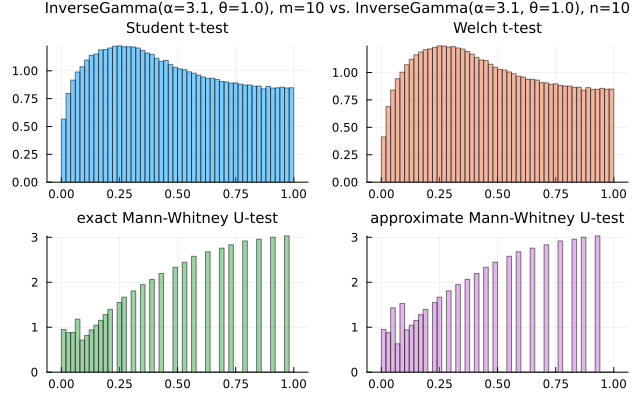

In [14]:
hist_p_values(InverseGamma(3.1, 1), 10, InverseGamma(3.1, 1), 10; bin=0:0.02:1, continuity_correction=false)

## P値の経験累積分布関数のグラフ

  1.298046 seconds (52.75 M allocations: 4.143 GiB, 35.68% gc time)


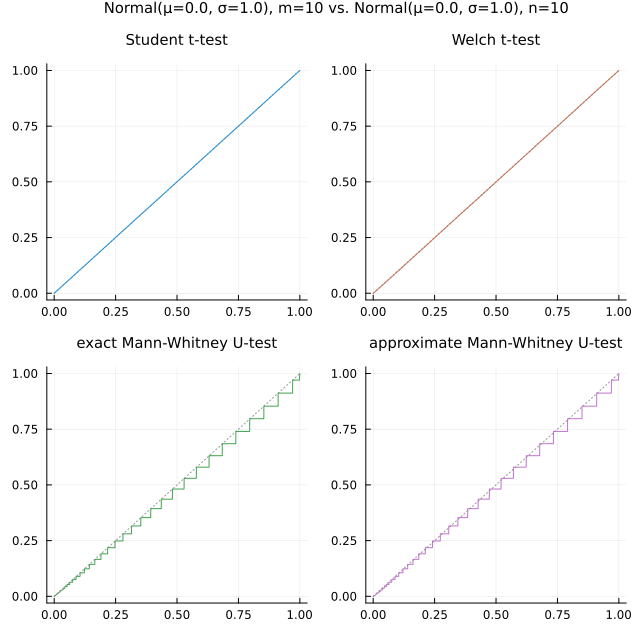

In [15]:
ecdf_p_values(Normal(), 10, Normal(), 10)

  1.142002 seconds (52.74 M allocations: 4.142 GiB, 26.99% gc time)


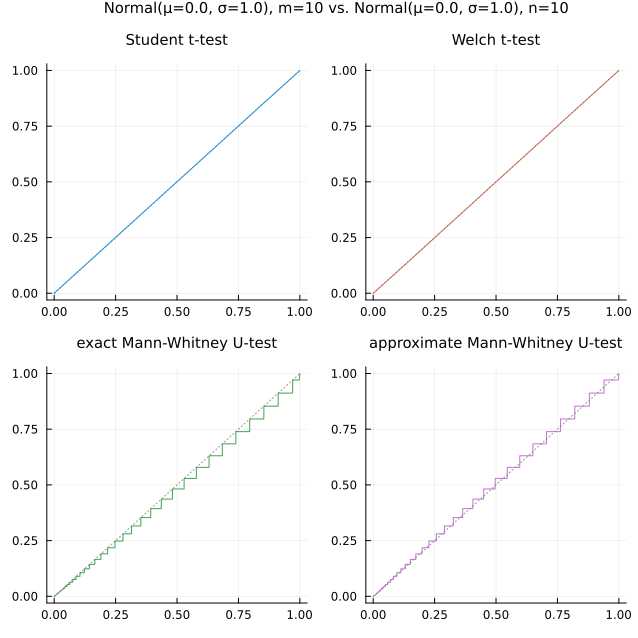

In [16]:
ecdf_p_values(Normal(), 10, Normal(), 10; continuity_correction=false)

  1.145718 seconds (41.82 M allocations: 3.803 GiB, 34.90% gc time)


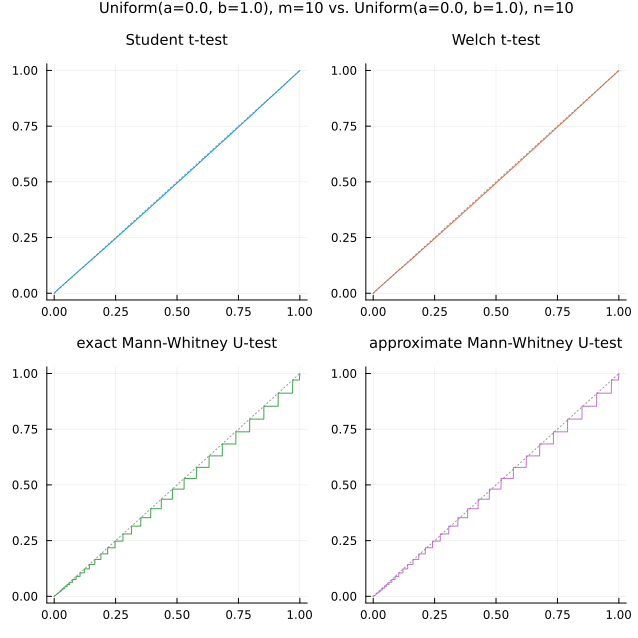

In [17]:
ecdf_p_values(Uniform(), 10, Uniform(), 10)

  0.972087 seconds (41.82 M allocations: 3.804 GiB, 26.04% gc time)


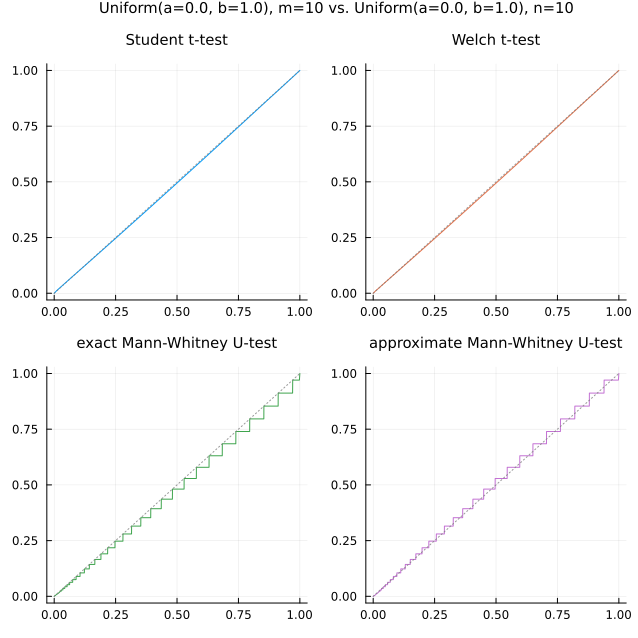

In [18]:
ecdf_p_values(Uniform(), 10, Uniform(), 10; continuity_correction=false)

skewness(dist) = 41.952353926806026


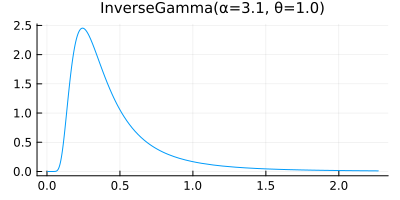

In [19]:
dist = InverseGamma(3.1, 1)
@show skewness(dist)
plot(x -> pdf(dist, x), 0, 5std(dist); title=distname(dist))

  1.254897 seconds (42.33 M allocations: 3.875 GiB, 35.14% gc time)


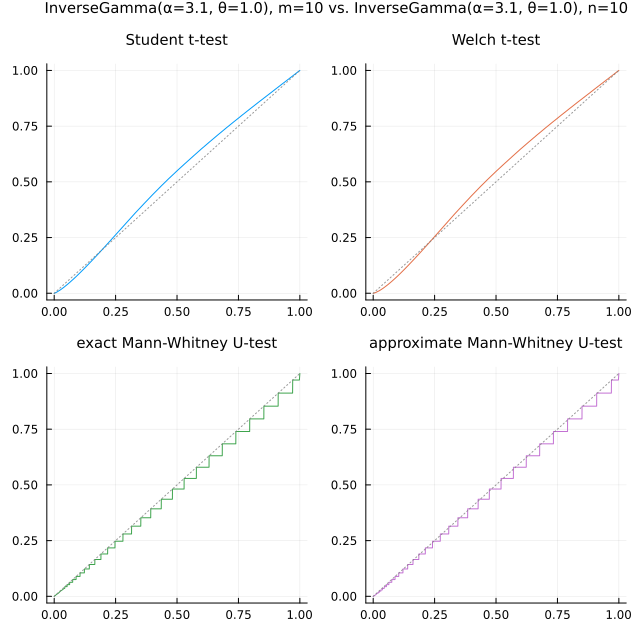

In [20]:
ecdf_p_values(InverseGamma(3.1, 1), 10, InverseGamma(3.1, 1), 10)

  1.090935 seconds (42.32 M allocations: 3.874 GiB, 26.45% gc time)


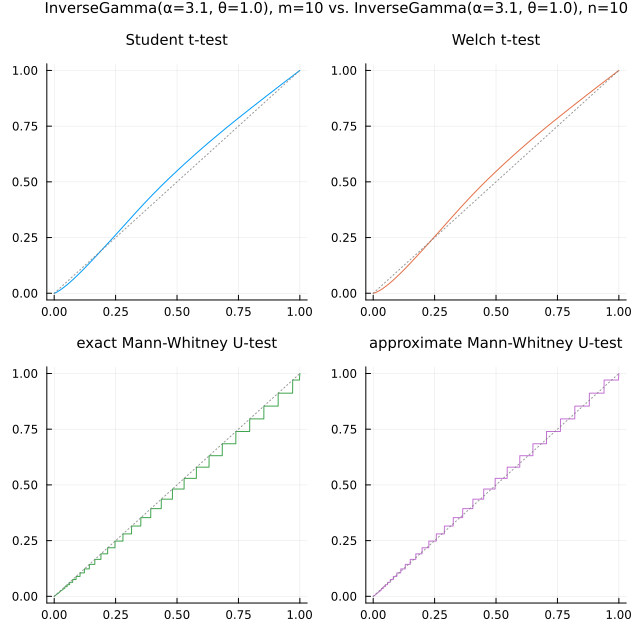

In [21]:
ecdf_p_values(InverseGamma(3.1, 1), 10, InverseGamma(3.1, 1), 10; continuity_correction=false)

  1.267098 seconds (42.32 M allocations: 3.875 GiB, 36.32% gc time)


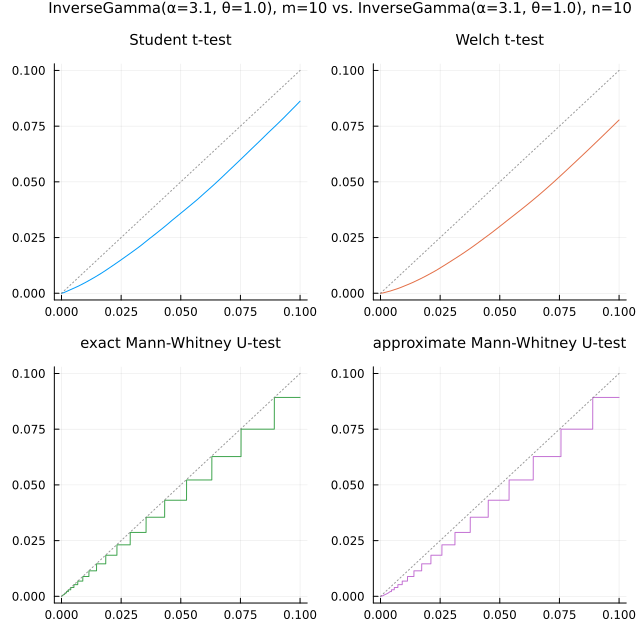

In [22]:
ecdf_p_values(InverseGamma(3.1, 1), 10, InverseGamma(3.1, 1), 10; maxalpha=0.1)

  1.054229 seconds (42.31 M allocations: 3.873 GiB, 26.05% gc time)


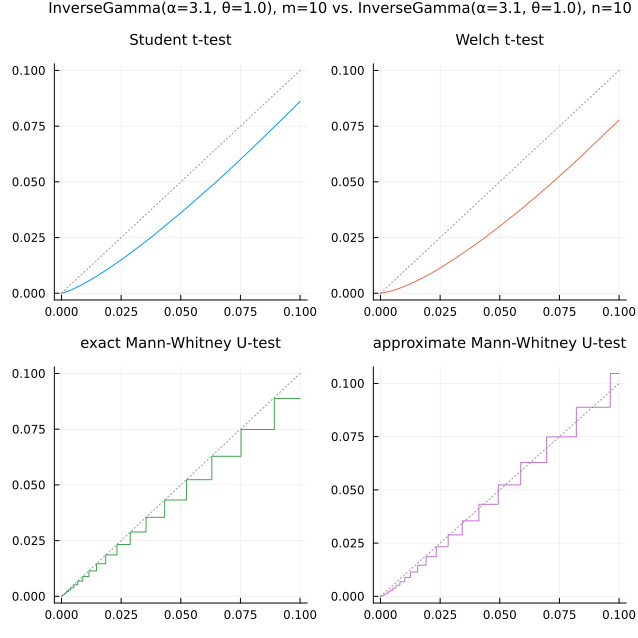

In [23]:
ecdf_p_values(InverseGamma(3.1, 1), 10, InverseGamma(3.1, 1), 10; maxalpha=0.1, continuity_correction=false)

  0.897402 seconds (38.34 M allocations: 2.360 GiB, 38.44% gc time)


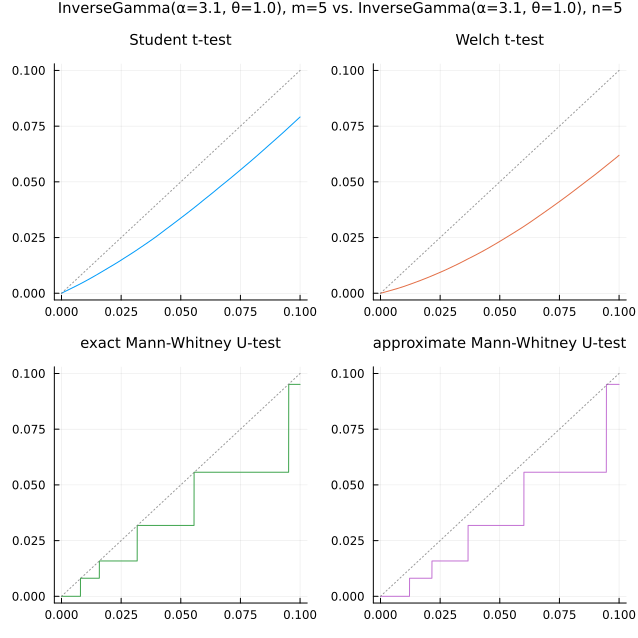

In [24]:
ecdf_p_values(InverseGamma(3.1, 1), 5, InverseGamma(3.1, 1), 5; maxalpha=0.1)

  0.667204 seconds (38.33 M allocations: 2.359 GiB, 24.37% gc time)


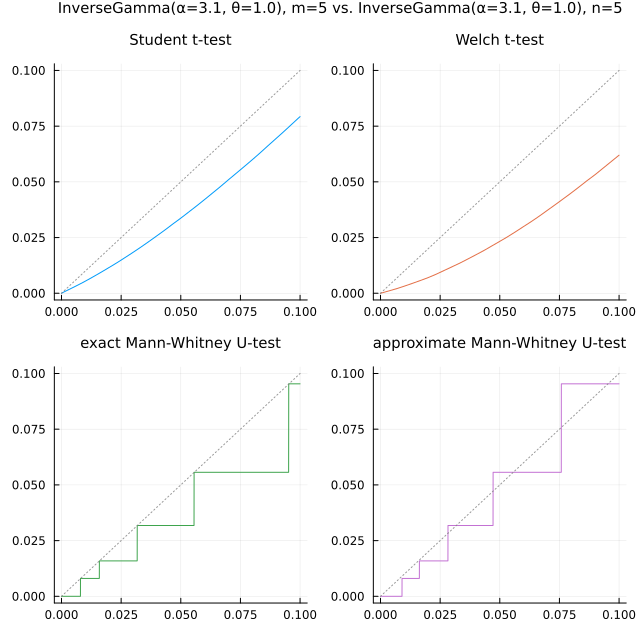

In [25]:
ecdf_p_values(InverseGamma(3.1, 1), 5, InverseGamma(3.1, 1), 5; maxalpha=0.1, continuity_correction=false)

  1.046077 seconds (42.31 M allocations: 3.097 GiB, 36.51% gc time)


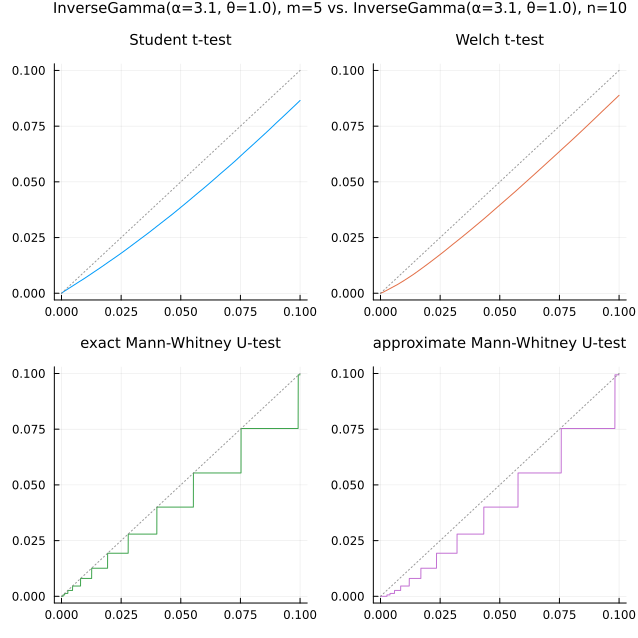

In [26]:
ecdf_p_values(InverseGamma(3.1, 1), 5, InverseGamma(3.1, 1), 10; maxalpha=0.1)

  0.901657 seconds (42.31 M allocations: 3.096 GiB, 25.37% gc time)


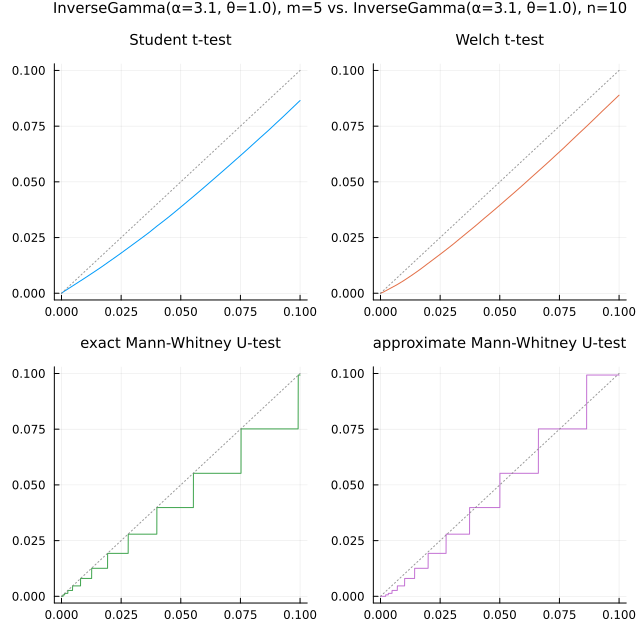

In [27]:
ecdf_p_values(InverseGamma(3.1, 1), 5, InverseGamma(3.1, 1), 10; maxalpha=0.1, continuity_correction=false)

  1.446001 seconds (46.71 M allocations: 4.625 GiB, 33.54% gc time)


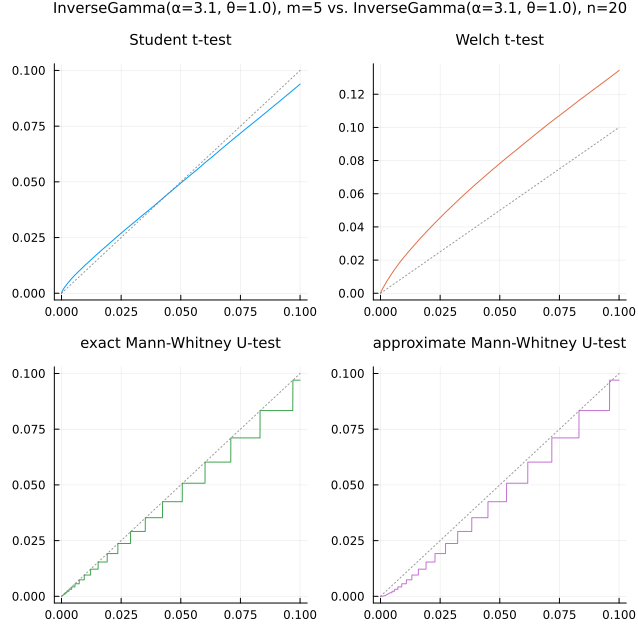

In [28]:
ecdf_p_values(InverseGamma(3.1, 1), 5, InverseGamma(3.1, 1), 20; maxalpha=0.1)

  1.207582 seconds (46.69 M allocations: 4.623 GiB, 25.67% gc time)


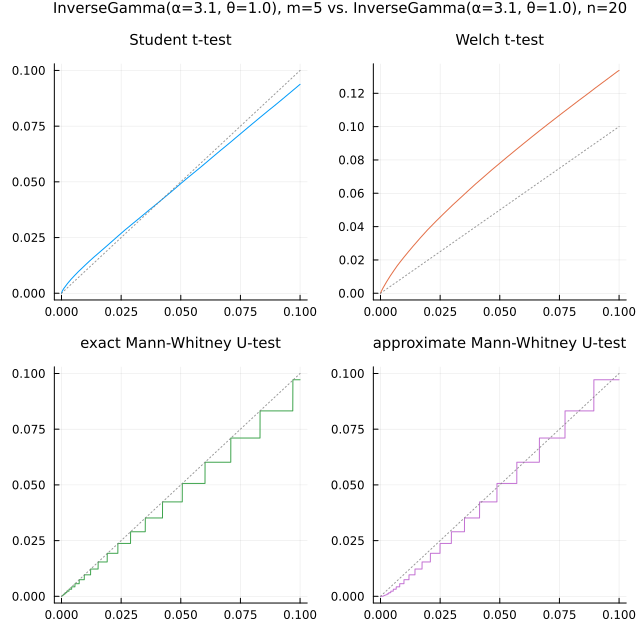

In [29]:
ecdf_p_values(InverseGamma(3.1, 1), 5, InverseGamma(3.1, 1), 20; maxalpha=0.1, continuity_correction=false)